In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;

In [2]:
import nbimporter
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
import time
import math

Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\SpatialMapping.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\commons\utility\pickle_util.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\DataEnrichment.ipynb
Importing Jupyter notebook from D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb


In [3]:
data = sm.run(['jun'])

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-jun14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-jun14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Result Saved in ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-14.p


In [336]:
df = data.copy()
columns = ['datetime', 'zone', 'weatherCondition', 'humidity', 'pressure', 'temperature', 'windDirection', 'windSpeed']

In [337]:
df2 = df[columns]
df2g = dis.encode(df2, ['zone', 'weatherCondition'])
df2g = df2.groupby(columns).size().reset_index(name='counts')
df2g['datetime'] = pd.to_datetime(df2g['datetime'], format='%m-%d-%Y:%H').apply(lambda x: time.mktime(x.timetuple()))

D:\Academics\MLRepoNew\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/zone.p
Result Saved in ../data/encodedMappings/weatherCondition.p


In [338]:
df2g['counts'].describe()

count    93164.000000
mean        14.384258
std         26.169024
min          1.000000
25%          1.000000
50%          5.000000
75%         16.000000
max        433.000000
Name: counts, dtype: float64

<AxesSubplot:ylabel='Frequency'>

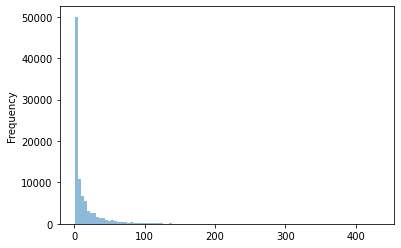

In [339]:
df2g['counts'].plot.hist( bins=100, alpha=0.5)

In [340]:
from sklearn.preprocessing import MinMaxScaler
counts = df2g['counts']
datetime = df2g['datetime']
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df2g) 
df2g.loc[:,:] = scaled_values
df2g['counts'] = counts
df2g['datetime'] = datetime

In [341]:
bins = [0, 11, 51, np.inf]
names = ['low', 'med', 'high']

df2g['label'] = pd.cut(df2g['counts'], bins, labels=names)

In [342]:
df2g = dis.encode(df2g, ['label'])

Result Saved in ../data/encodedMappings/label.p


In [343]:
df2g

,datetime,zone,weatherCondition,humidity,pressure,temperature,windDirection,windSpeed,counts,label
0,1.401561e+09,0.003968,0.000000,0.519481,0.884615,0.366171,0.333333,0.500,22,2
1,1.401561e+09,0.015873,0.000000,0.519481,0.884615,0.366171,0.333333,0.500,3,1
2,1.401561e+09,0.023810,0.000000,0.519481,0.884615,0.366171,0.333333,0.500,1,1
3,1.401561e+09,0.027778,0.000000,0.519481,0.884615,0.366171,0.333333,0.500,1,1
4,1.401561e+09,0.039683,0.000000,0.519481,0.884615,0.366171,0.333333,0.500,13,2
...,...,...,...,...,...,...,...,...,...,...
93159,1.404149e+09,0.972222,0.823529,0.467532,0.576923,0.877323,0.552778,0.125,8,1
93160,1.404149e+09,0.976190,0.823529,0.467532,0.576923,0.877323,0.552778,0.125,1,1
93161,1.404149e+09,0.992063,0.823529,0.467532,0.576923,0.877323,0.552778,0.125,7,1
93162,1.404149e+09,0.996032,0.823529,0.467532,0.576923,0.877323,0.552778,0.125,2,1


In [344]:
X = df2g.values[:,:len(columns)]
y = df2g.values[:,-1]

In [345]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X = sc.fit_transform(X)

In [346]:
def cost_function(X, Y, B):
    m = len(Y)
    J = np.sum((X.dot(B) - Y) ** 2)/(2 * m)
    return J

In [347]:
def batch_gradient_descent(X, Y, B, alpha, iterations): 
    cost_history = [0] * iterations
    m = len(Y)
    
    for iteration in range(iterations):
        #print(iteration)
        # Hypothesis Values
        h = X.dot(B)
        # Difference b/w Hypothesis and Actual Y
        loss = h-Y
        # Gradient Calculation
        gradient = X.T.dot(loss) / m
        # Changing Values of B using Gradient
        B = B - alpha * gradient
        # New Cost Value
        cost = cost_function(X, Y, B)
        cost_history[iteration] = cost
    return B, cost_history

In [348]:
m = 90000
f = len(columns)
X_train = X[:m,:f]
X_train = np.c_[np.ones(len(X_train),dtype='int64'),X_train]
y_train = y[:m]
                        
X_test = X[m:,:f]
X_test = np.c_[np.ones(len(X_test),dtype='int64'),X_test]
y_test = y[m:]

In [349]:
# Initial Coefficients
B = np.zeros(X_train.shape[1])
alpha = 0.005
iter_ = 10000
newB, cost_history = batch_gradient_descent(X_train, y_train, B, alpha, iter_)

<ipython-input-346-440758db79df>:3: RuntimeWarning: overflow encountered in square
  J = np.sum((X.dot(B) - Y) ** 2)/(2 * m)


In [350]:
def pred(x_test, newB):
    return np.floor(x_test.dot(newB))

In [351]:
y_ = pred(X_test,newB)


In [352]:
def r2(y_,y):
    sst = np.sum((y-y.mean())**2)
    ssr = np.sum((y_-y)**2)
    r2 = 1-(ssr/sst)
    return(r2)


In [353]:
r2(y_,y_test)

nan

In [354]:
from sklearn import metrics

In [355]:
print(metrics.mean_absolute_error(y_test, y_))
print(metrics.mean_squared_error(y_test, y_))
print(metrics.r2_score(y_test, y_))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
matrix = confusion_matrix(y_test, y_)
print(matrix)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report = classification_report(y_test, y_)
print(report)

In [ ]:
y_train